# ResNet


Deep neural networks are hard to train because of valishing gradient problem. As we want to update the weights - we need to use backpropagation.

![vanihing gradient](resources/images/M_4/vanihing_gradient.png)


In deep neural networks we face the problem of vanishing gradients. Backpropagation uses chain rule - the repeted multiplication of derivatives - makes the weights extremly small while reaching to the earlier layers. 

Residual networks are also deep networks. But they provide a mean to counter this vanishing gradient problem. Resnet introduced the concept of __skip connection__ that resolves this problem. 

![skip connection](resources/images/M_4/skip_connection.png)


With Traditional CNN Architecture layers are stacked in sequence. What happens here is convolutional layers are stacked like traditional layers, but there is also a skip connection which adds the original input to the output layer. Because of this skip connection, the values will not reach to a small value - as we are missing some layers.

![identity](resources/images/M_4/identity.png)

Here $X$ is the input and $F(X)$ is the output. In traditional CNN we pass the input ($x$), which travels layer by layer and we compute the output $Y=F(X)$. But here we are performing $Y=F(X)+X$ i.e. we are adding the function outout with the original input. The main logic behind residual network is to make your function of $F(X)=0$ - that is to make the input and output equal($Y=X$). Simple we can say that the network will learn from the differnce from the input and the output, so that the overall accuracy can be increaded. 

![identity](resources/images/M_4/res_archi.png)

![identity](resources/images/M_4/archi.png)


Deeper neural networks are more difficult to train. Residual learning was introduced to ease the training of networks that are substantially deeper than those used previously. ResNet explicitly reformulates the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. On the ImageNet dataset this method was evaluated with residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. This technique can also be applied to the CIFAR-10 with 100 and 1000 layers.

https://arxiv.org/abs/1512.03385


# Dataset

https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
SEED = 1000
IMG_SIZE = 50
BATCH_SIZE = 128

TRAIN_DIR = 'E:DATASETS/classification/natural_scenes/train'
VALID_DIR = 'E:DATASETS/classification/natural_scenes/test'
TEST_DIR = 'E:DATASETS/classification/natural_scenes/pred'

### Check the dataset

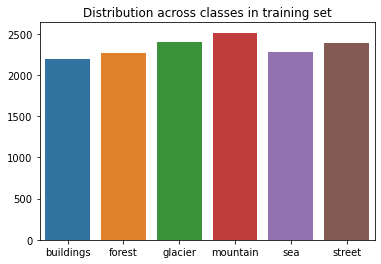

Total Train Examples = 14034


In [4]:
class_names = []
class_count = []
TRAIN_EXAMPLES = 0
for folder in  os.listdir(TRAIN_DIR) : 
    files = gb.glob(pathname= str( TRAIN_DIR + '//' + folder + '/*.jpg'))
    class_names.append(folder)
    class_count.append(len(files))
    TRAIN_EXAMPLES += len(files)
    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {TRAIN_EXAMPLES}')

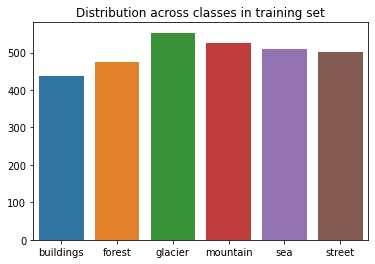

Total Train Examples = 3000


In [5]:
class_names = []
class_count = []
VALIDATION_EXAMPLES = 0
for folder in  os.listdir(VALID_DIR) : 
    files = gb.glob(pathname= str( VALID_DIR + '//' + folder + '/*.jpg'))
    class_names.append(folder)
    class_count.append(len(files))
    VALIDATION_EXAMPLES += len(files)
    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {VALIDATION_EXAMPLES}')

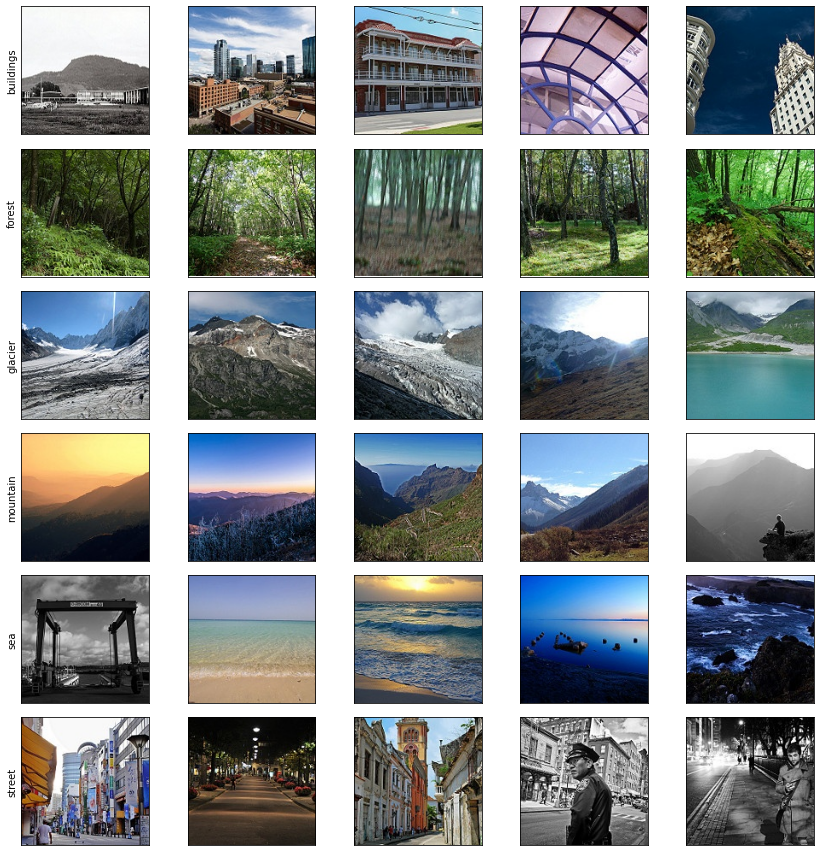

In [6]:
# diaplay 5 images from each class
plt.figure(figsize=(12,12))
i=0
for c in os.listdir(TRAIN_DIR):  
    path = os.path.join(TRAIN_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB) 
        plt.subplot(6,5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break

plt.tight_layout()        
plt.show() 

In [7]:
train_gen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation 
    # (strictly between 0 and 1)
    validation_split=0.0,
    # datatype
    dtype=tf.float32,
)

test_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input, 
    dtype=tf.float32
)

In [8]:
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 14034 images belonging to 6 classes.


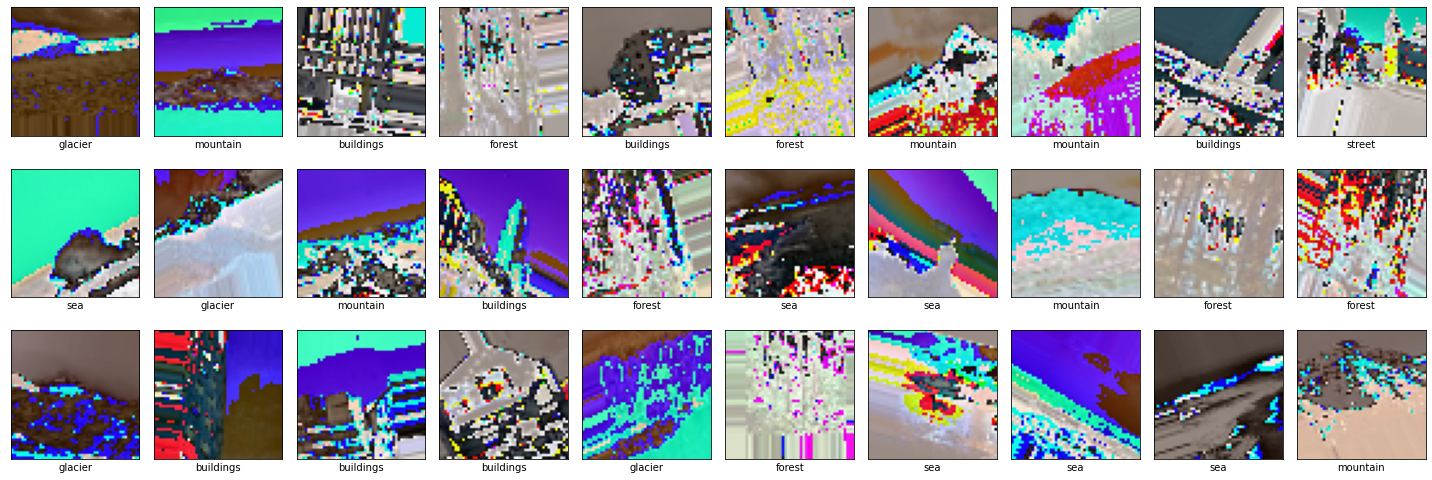

In [9]:
# display 30 items  for a batch
imgs, labels = next(train_batch)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(3,10,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [10]:
valid_batch = train_gen.flow_from_directory(
    directory = VALID_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 3000 images belonging to 6 classes.


In [22]:
test_batch = test_gen.flow_from_directory(
    directory = VALID_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    seed = SEED
)

Found 3000 images belonging to 6 classes.


In [11]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [12]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    ### match the dimension
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [13]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
    # Satge Conv1
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
    # stage Conv2_x
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
    # stage Conv3_x
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    # stage Conv4_x
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    # stage Conv5_x
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(10, activation='softmax', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model
   

In [14]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 25, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [15]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Learning rate:  0.001


In [17]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = TRAIN_EXAMPLES // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = VALIDATION_EXAMPLES // BATCH_SIZE,
              callbacks=lr_scheduler,
              verbose=2
             )

Epoch 1/50
Learning rate:  0.001
109/109 - 34s - loss: 1.4757 - accuracy: 0.4892 - val_loss: 2.4325 - val_accuracy: 0.2249
Epoch 2/50
Learning rate:  0.001
109/109 - 22s - loss: 1.0296 - accuracy: 0.6108 - val_loss: 2.9532 - val_accuracy: 0.2500
Epoch 3/50
Learning rate:  0.001
109/109 - 26s - loss: 0.9641 - accuracy: 0.6398 - val_loss: 2.0143 - val_accuracy: 0.3889
Epoch 4/50
Learning rate:  0.001
109/109 - 25s - loss: 0.8672 - accuracy: 0.6814 - val_loss: 1.3065 - val_accuracy: 0.5890
Epoch 5/50
Learning rate:  0.001
109/109 - 22s - loss: 0.8071 - accuracy: 0.7016 - val_loss: 1.1278 - val_accuracy: 0.6199
Epoch 6/50
Learning rate:  0.001
109/109 - 27s - loss: 0.7793 - accuracy: 0.7135 - val_loss: 0.9805 - val_accuracy: 0.6678
Epoch 7/50
Learning rate:  0.001
109/109 - 25s - loss: 0.7995 - accuracy: 0.7129 - val_loss: 8.3994 - val_accuracy: 0.3842
Epoch 8/50
Learning rate:  0.001
109/109 - 24s - loss: 0.7903 - accuracy: 0.7178 - val_loss: 7.8539 - val_accuracy: 0.4195
Epoch 9/50
Learn

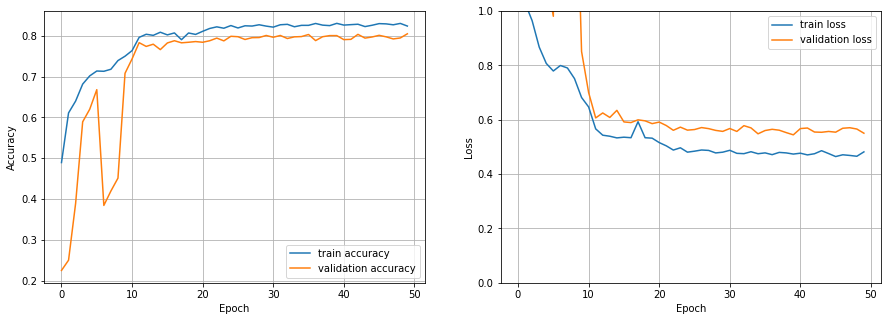

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()